In [23]:
from __future__ import print_function
import gc
import os
import sys
import math
import time
import scipy.stats as ss
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from models.PCConvNet import PCConvNet, PCConvNetCls, PCConvNetContrastive
from models.PCConvLstmNet import PCConvLstmNet, PCConvLstmNetCls
from dataLoaders.PitchContourDataset import PitchContourDataset
from dataLoaders.PitchContourDataloader import PitchContourDataloader
from dataLoaders.MASTDataset import MASTDataset
from dataLoaders.MASTDataloader import MASTDataloader
from tensorboard_logger import configure, log_value
from sklearn import metrics
import eval_utils
import train_utils
import dill
import matplotlib.pyplot as plot
from sklearn.manifold import TSNE
import seaborn as sns
from contrastive_utils import ContrastiveLoss
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix
sns.set(rc={'figure.figsize':(11.7,8.27)})
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# initialize training parameters
RUN = 110
NUM_EPOCHS = 300 #250 #2000
NUM_BATCHES = 10
SEGMENT = '2'
MTYPE = 'conv'
CTYPE = 0
# initialize dataset, dataloader and created batched data

#SET CONSTANTS
metric_type = {0:'musicality', 1:'note accuracy',2:'Rhythm Accuracy',3:'tonality'}
instrument = 'ALL'
cross_instrument = 'ALL'
experiment = 'mixed'
METRIC = 1# 0: Musicality, 1: Note Accuracy, 2: Rhythmic Accuracy, 3: Tone Quality
BAND = 'middle'
ADD_NOISE_TEST = False
ADD_NOISE_VALID = False
NOISE_SHAPE = 'triangular'  #triangular, normal, or uniform
INPUT_REP = 'Cepstrum'

#SET TRAINING CONSTANTS
contrastive = True
MSE_LOSS_STR = 1
CONTR_LOSS_STR = 0
num_labels = 5
classification = False
model_type = 'reg' if not classification else str(num_labels)+'class'
#HYPERPARAMETERS
LR_RATE = 0.005 #0.01
W_DECAY = 1e-5 #5e-4 #1e-5
MOMENTUM = 0.9
NAME = '{0}_{1}_{2}_{3}_{4}_{5}'.format(BAND, instrument, metric_type[METRIC], INPUT_REP, model_type, experiment)

In [25]:
datasets = {'flute':{'test':'/media/SSD/FBA/crossInstr/middle_Flute__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Flute__train_fixed.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Flute__valid.dill'},
            'clarinet':{'test':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__train.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__valid.dill'},
            'saxophone':{'test':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__train.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__valid.dill'}}
datasets_all = {'flute': '/media/SSD/FBA/crossInstr/middle_Flute_.dill', 'saxophone': '/media/SSD/FBA/crossInstr/middle_Alto Saxophone_.dill', 'clarinet':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet_.dill', 
                'ALL':'/media/SSD/FBA/saved_dill/middle_2_new_dataPC.dill'}
if BAND != 'middle':
    datasets_all = {'ALL': '/media/SSD/FBA/saved_dill/symphonic_2_data_new2.dill'}
file_name = BAND + '_' + str(SEGMENT) + '_data'
with open(datasets_all[cross_instrument], 'rb') as f:
    NUM_DATA_POINTS = len(dill.load(f))
if sys.version_info[0] < 3:
    data_path = 'dat/' + file_name + '.dill'
    mast_path = '/Users/Som/GitHub/Mastmelody_dataset/f0data'
else:
    if torch.cuda.is_available():
        data_path = '/home/data_share/FBA/fall19/data/pitch_contour/' + BAND + '_2_pc_3.dill'
    else:
        data_path = '/Volumes/Farren/python_stuff/dat/' + BAND + '_2_data_3.dill'

    mast_path = '/home/apati/MASTmelody_dataset/f0data'

if BAND == 'mast':
    dataset = MASTDataset(mast_path)
    dataloader = MASTDataloader(dataset)
    CTYPE = 1
else:
    dataset = PitchContourDataset(datasets_all[cross_instrument])
    dataloader = PitchContourDataloader(dataset, NUM_DATA_POINTS, NUM_BATCHES)


tr1, v1, vef, te1, tef = dataloader.create_split_data(1000, 500) #1000, 500 | 1500, 500 | 2000, 1000
tr2, v2, _, te2, _ = dataloader.create_split_data(1500, 500)
tr3, v3, _, te3, _ = dataloader.create_split_data(2000, 1000)
#tr4, v4, _, te4, _ = dataloader.create_split_data(2500, 1000)
#tr5, v5, _, te5, _ = dataloader.create_split_data(3000, 1500)
#tr6, v6, vef, te6, tef = dataloader.create_split_data(4000, 2000)
training_data = tr1 + tr2 + tr3 #+ tr2 + tr3 #+ tr4 + tr5 + tr6     # this is the proper training data split
validation_data = vef #+ v2 + v3 + v4 + v5 + v6
testing_data = te1 + te2 + te3 #+ te4 + te5 + te6


## augment data
aug_training_data = train_utils.augment_data(training_data)
aug_training_data = train_utils.augment_data(aug_training_data)
aug_validation_data = validation_data  #train_utils.augment_data(validation_data)


## initialize model
if MTYPE == 'conv':
    if BAND == 'mast':
        perf_model = PCConvNetCls(1)
    else:
        perf_model = PCConvNet(0)#PCConvNetContrastive(0, num_classes=num_labels, regression= not classification)
elif MTYPE == 'lstm':
    if BAND == 'mast':
        perf_model = PCConvLstmNetCls()
    else:
        perf_model = PCConvLstmNet()        
if torch.cuda.is_available():
    perf_model.cuda()
if BAND == 'mast':
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.MSELoss()

# test
# test of full length data
#test_loss, test_r_sq, test_accu, test_accu2 = eval_utils.eval_model(perf_model, criterion, testing_data, METRIC, MTYPE, CTYPE)
#print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Testing Loss: ', test_loss, ' R-sq: ', test_r_sq, ' Accu:', test_accu, test_accu2))

# validate and test on best validation model
# read the model
#filename = file_info + '_Reg'

2616
{'year': '2013', 'band': 'middleschool', 'instrumemt': 'Alto Saxophone', 'student_id': 28588, 'segment': 2, 'audio': (array([0.0034837 , 0.00544147, 0.00478444, ..., 0.0046058 , 0.00369738,
       0.00392769], dtype=float32), 22050), 'pitch_contour': array([0., 0., 0., ..., 0., 0., 0.]), 'ratings': (0.5, 0.9, 0.9, 0.6), 'class_ratings': [5.0, 9.0, 9.0, 6.0], 'length': 4400}


In [26]:
filename = 'middle_ALL_musicality_Cepstrum_reg_paper-results_SEED 3 _best'#NAME  #+ '_best' if best else NAME #if instrument == 'saxophone' else NAME + '_best'
def eval(filename):
    if torch.cuda.is_available():
        perf_model.cuda()
        #perf_model.load_state_dict(torch.load('/Users/michaelfarren/Desktop/MusicPerfAssessment-master/src/runs/' + filename + '.pt'))
        perf_model.load_state_dict(torch.load('paper_runs/saved_models/' + filename))

    else:
        perf_model.load_state_dict(torch.load('pc_contrastive_runs/' + filename + '.pt', map_location=lambda storage, loc: storage))

    print(len(aug_training_data))
    c_loss = ContrastiveLoss(num_labels=5)
    ce_loss = nn.CrossEntropyLoss()
    #pred, y = eval_utils.eval_acc_contrastive(perf_model, c_loss, vef, METRIC, 
                                                                       #MTYPE, CTYPE, extra_outs = 0, 
                                                                       #classification = True, 
                                                                       #criterion_CE = ce_loss, 
                                                                       #preds = True)
    pred, y = eval_utils.eval_model_preds(perf_model, criterion, testing_data, METRIC, MTYPE, CTYPE)
    return pred, y

#val_loss, val_r_sq, val_accu, val_accu2 = eval_utils.eval_model(perf_model, criterion, vef, METRIC, MTYPE, CTYPE)
#print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Valid Loss: ', val_loss, ' R-sq: ', val_r_sq, ' Accu:', val_accu, val_accu2))

#test_loss, test_r_sq, test_accu, test_accu2 = eval_utils.eval_model(perf_model, criterion, testing_data, METRIC, MTYPE, CTYPE)
#print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Testing Loss: ', test_loss, ' R-sq: ', test_r_sq, ' Accu:', test_accu, test_accu2))

Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
base
0.47986575961112976


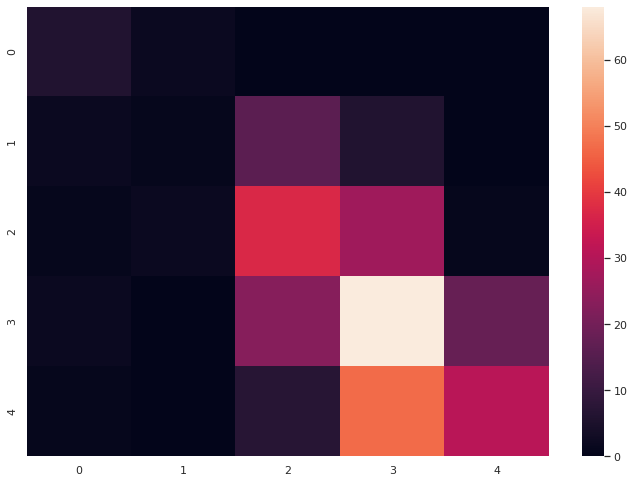

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       0.20      0.04      0.07        25
           2       0.45      0.54      0.49        68
           3       0.46      0.61      0.53       111
           4       0.62      0.36      0.46        86

    accuracy                           0.48       298
   macro avg       0.45      0.46      0.43       298
weighted avg       0.48      0.48      0.46       298

Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
mix
0.4932886064052582


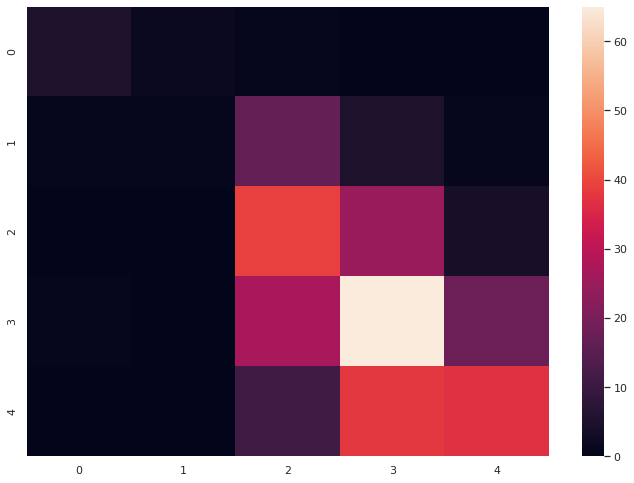

              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.33      0.04      0.07        25
           2       0.41      0.57      0.48        68
           3       0.49      0.59      0.53       111
           4       0.62      0.43      0.51        86

    accuracy                           0.49       298
   macro avg       0.51      0.45      0.45       298
weighted avg       0.50      0.49      0.48       298

Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (0). Kernel size: (7). Kernel size can't be greater than actual input size
cont
0.34563758969306946


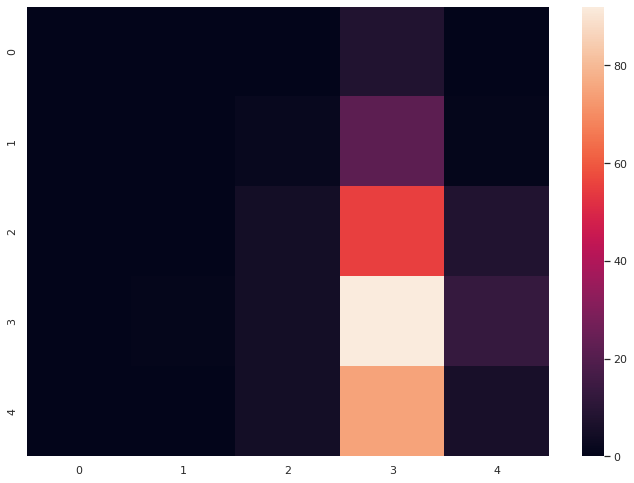

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        25
           2       0.29      0.07      0.12        68
           3       0.37      0.83      0.51       111
           4       0.21      0.07      0.11        86

    accuracy                           0.35       298
   macro avg       0.17      0.19      0.15       298
weighted avg       0.26      0.35      0.25       298



/home/pseshadri/miniconda3/envs/modelrunner/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pseshadri/miniconda3/envs/modelrunner/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pseshadri/miniconda3/envs/modelrunner/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [100]:
#toggle interactive plots
#%matplotlib notebook
#symphonic_ALL_Rhythm Accuracy_Cepstrum_5class_CE_CLASSIFICATION-paper-results_SEED 0 _best
dic = {'middle': {'Regression': {'base': 'middle_ALL_{}_Cepstrum_reg_BASELINE_REG-paper-results_SEED 0 _best',
                                  'mix': 'middle_ALL_{}_Cepstrum_reg_paper-results_SEED 2 _best',
                                  'cont': 'middle_ALL_{}_Cepstrum_reg_Contrastive-only-paper-results_SEED 0 _best'},
                   'Classification': {'base':'middle_ALL_{}_Cepstrum_5class_CE_CLASSIFICATION-paper-results_SEED 0 _best',
                                      'cont':'middle_ALL_{}_Cepstrum_5class_Contrastive-only-Classification-paper-results_SEED 0 _best',
                                      'mix': 'middle_ALL_{}_Cepstrum_5class_Contrastive-mix-Classification-paper-results_SEED 0 _best'}},
       'symphonic': {'Regression': {'base': 'symphonic_ALL_{}_Cepstrum_reg_BASELINE_REG-paper-results_SEED 0 _best',
                                  'mix': 'symphonic_ALL_{}_Cepstrum_reg_MixReg-paper-results_SEED 0 _best',
                                  'cont': 'symphonic_ALL_{}_Cepstrum_reg_BASELINE_REG-CONTRASTIVE-ONLY-paper-results2_SEED 0 _best'},
                   'Classification': {'base':'symphonic_ALL_{}_Cepstrum_5class_CE_CLASSIFICATION-paper-results_SEED 0 _best',
                                      'cont':'symphonic_ALL_{}_Cepstrum_5class_ContrastiveOnlyClass-paper-results_SEED 0_best',
                                      'mix': 'symphonic_ALL_{}_Cepstrum_5class_MIX_CLASSIFICATION-paper-results_SEED 0 _best'}}}
def macro_avg(y, predictions):
    avg = 0
    for x in np.unique(y):
        avg += np.sum(y[y == x] == predictions[predictions == x]) / y[y == x].shape[0]
    return avg /np.unique(y).shape[0]
        
metrics = ['Rhythm Accuracy']
types = ['base', 'mix', 'cont']
evals = dict()
evalList = []
for x in metrics:
       for yi in types:
           if yi == 'base2':
               perf_model = PCConvNet(0).cuda()
           else:
               perf_model = PCConvNetContrastive(0, num_classes=5, regression= False).cuda()
           filename = dic['symphonic']['Classification'][yi].format(x)
           perf_model.load_state_dict(torch.load('paper_runs/saved_models/' + filename))
           preds, y =  eval_utils.eval_acc_contrastive(perf_model, c_loss, vef, METRIC, MTYPE, CTYPE, criterion_CE=nn.CrossEntropyLoss(), preds=True)
           #print(perf_model.classifier(preds))
           preds = torch.argmax(perf_model.classifier(preds), dim=1).cpu().detach().numpy()
           c_loss = ContrastiveLoss(num_labels=5)
           #print(y.shape)
           y = c_loss.label_map(y.T.flatten()).cpu()
           #print(y, preds)
           loss_contrastive_test, acc_contrastive_test, ce_loss_test = eval_utils.eval_acc_contrastive(perf_model, c_loss, vef, METRIC, MTYPE, CTYPE, criterion_CE=nn.CrossEntropyLoss())
           #test_loss, test_r_sq, test_accu, test_accu2 = eval_utils.eval_model(perf_model, criterion, testing_data, METRIC, MTYPE, CTYPE)
           evals[x] = dict()
           evals[x][yi] = dict()
           evals[x][yi]['test rsq'] = acc_contrastive_test #test_r_sq
           #preds = torch.Tensor(preds).cpu()
           #evals[x][yi]['silhouette'] = silhouette_score(preds, y)
           #evals[x][yi]['db'] =  davies_bouldin_score(preds, y)
           print(yi)
           print(acc_contrastive_test.item())# , silhouette_score(preds, y),davies_bouldin_score(preds, y))
           conf_mat = confusion_matrix(y, preds)
           heatmap = sns.heatmap(conf_mat)
           plot.show()
           rep = classification_report(y, preds)
           print(rep)

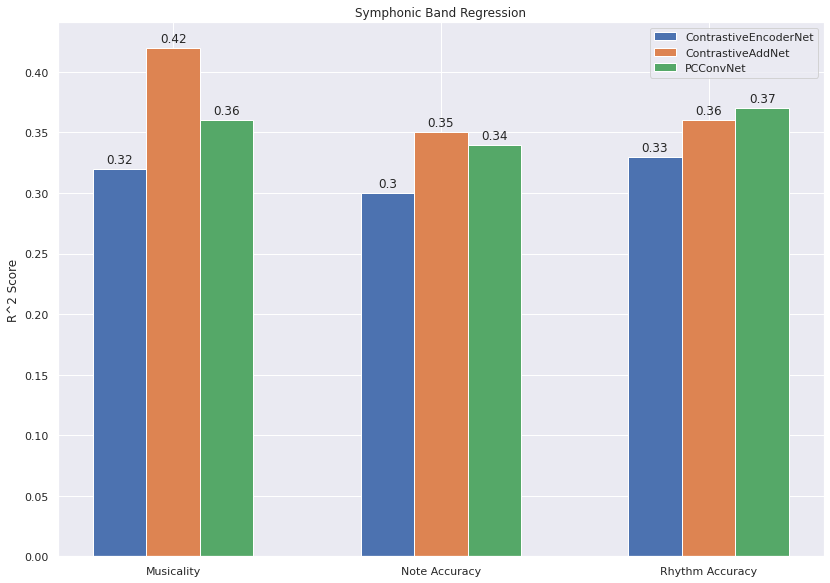

In [94]:
musicality = [{'musicality': {'base': {'test rsq': 0.4631752282971854, 'silhouette': -0.08213208, 'db': 8.049263733761743}}},
             {'musicality': {'mix': {'test rsq': 0.5273371326602231, 'silhouette': -0.009416969, 'db': 3.6195695988514744}}},
             {'musicality': {'cont': {'test rsq': 0.4960225450627549, 'silhouette': -0.0021775814, 'db': 4.0824345829658455}}}]
musicality = [{'musicality': {'base': {'test rsq': 0.27848532550446403, 'silhouette': -0.024106322, 'db': 9.995524752374047}}},
              {'musicality': {'mix': {'test rsq': 0.34908156735325935, 'silhouette': -0.02051328, 'db': 6.053866492813366}}},
              {'musicality': {'cont': {'test rsq': 0.279, 'silhouette': -0.019308027, 'db': 7.110031733662607}}}]
musicality = [{'musicality': {'base': {'test rsq': 0.48, 'silhouette': -0.08881192, 'db': 8.58306055136453}}},
              {'musicality': {'mix': {'test rsq': 0.49, 'silhouette': -0.014821606, 'db': 8.660017643254463}}},
              {'musicality': {'cont': {'test rsq': 0.39, 'silhouette': -0.09382071, 'db': 13.618438418232483}}}]
musicality = [{'musicality': {'base': {'test rsq': 0.4846, 'silhouette': -0.035610557, 'db': 8.217865607917854}}},
              {'musicality': {'mix': {'test rsq': 0.3654, 'silhouette': -0.08941569, 'db': 9.792478244884865}}},
              {'musicality': {'cont': {'test rsq': 0.4538, 'silhouette': 0.009330231, 'db': 4.0484550758506455}}}]
#musicality = [round(x, 2) for x in musicality]
note = [{'note accuracy': {'base': {'test rsq': 0.5383042760252731, 'silhouette': -0.0054266048, 'db': 6.423139606850246}}},
        {'note accuracy': {'mix': {'test rsq': 0.5950734040710706, 'silhouette': 0.08393581, 'db': 9.889405431120869}}},
        {'note accuracy': {'cont': {'test rsq': 0.5552816266196312, 'silhouette': 0.09578275, 'db': 11.002306382423663}}}]
note = [{'note accuracy': {'base': {'test rsq': 0.3013813071770586, 'silhouette': -0.036242064, 'db': 14.889925800375327}}},
        {'note accuracy': {'mix': {'test rsq': 0.2887229236858916, 'silhouette': -0.03360408, 'db': 5.650331673438345}}},
        {'note accuracy': {'cont': {'test rsq': 0.27, 'silhouette': -0.033663288, 'db': 6.297449074125768}}}]
note = [{'note accuracy': {'base': {'test rsq':0.48, 'silhouette': -0.1428539, 'db': 12.233637434793255}}},
        {'note accuracy': {'mix': {'test rsq': 0.48, 'silhouette': -0.028002843, 'db': 8.16355170490836}}},
        {'note accuracy': {'cont': {'test rsq': 0.37, 'silhouette': -0.1375623, 'db': 14.501248043525333}}}]
note = [{'note accuracy': {'base': {'test rsq':0.6346, 'silhouette': -0.01434557, 'db': 7.774797647876592}}},
        {'note accuracy': {'mix': {'test rsq': 0.6115, 'silhouette': -0.06721786, 'db': 8.79790871112965}}},
        {'note accuracy': {'cont': {'test rsq': 0.6269, 'silhouette': 0.08394019, 'db': 8.179712886440166}}}]
#note = [round(x, 2) for x in note]
rhythm = [{'Rhythm Accuracy': {'base': {'test rsq': 0.49281923981650066, 'silhouette': -0.06736768, 'db': 5.628337356395157}}},
          {'Rhythm Accuracy': {'mix': {'test rsq': 0.5427275293812454, 'silhouette': -0.00096725253, 'db': 4.315263837487498}}},
          {'Rhythm Accuracy': {'cont': {'test rsq': 0.5070971453216659, 'silhouette': 0.00082458166, 'db': 4.910683949797827}}}]
rhythm = [{'Rhythm Accuracy': {'base': {'test rsq': 0.30276160927609785, 'silhouette': -0.05846928, 'db': 9.050997618385603}}},
          {'Rhythm Accuracy': {'mix': {'test rsq': 0.27879182223204335, 'silhouette': -0.03131785, 'db': 5.810455438832077}}},
          {'Rhythm Accuracy': {'cont': {'test rsq': 0.27, 'silhouette': -0.03196149, 'db': 6.699196903357925}}}]
rhythm = [{'Rhythm Accuracy': {'base': {'test rsq': 0.490, 'silhouette': -0.10658811, 'db': 10.764627921491492}}},
          {'Rhythm Accuracy': {'mix': {'test rsq': 0.49, 'silhouette': -0.029263552, 'db': 7.986976267317783}}},
          {'Rhythm Accuracy': {'cont': {'test rsq': 0.36, 'silhouette': -0.13255504, 'db': 11.122463646074202}}}]
rhythm = [{'Rhythm Accuracy': {'base': {'test rsq': 0.6231, 'silhouette': -0.0086510405, 'db': 5.457190942724827}}},
          {'Rhythm Accuracy': {'mix': {'test rsq': 0.5962, 'silhouette': -0.047678277, 'db': 10.61633267583423}}},
          {'Rhythm Accuracy': {'cont': {'test rsq': 0.6269, 'silhouette': 0.005410377, 'db': 3.9866344029575123}}}]
#rhythm = [round(x, 2) for x in rhythm]
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
criteria = 'test rsq'
labels = ['Musicality', 'Note Accuracy', 'Rhythm Accuracy']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]
mix = [musicality[1]['musicality']['mix'][criteria], note[1]['note accuracy']['mix'][criteria], rhythm[1]['Rhythm Accuracy']['mix'][criteria]]
base = [musicality[0]['musicality']['base'][criteria], note[0]['note accuracy']['base'][criteria], rhythm[0]['Rhythm Accuracy']['base'][criteria]]
cont = [musicality[2]['musicality']['cont'][criteria], note[2]['note accuracy']['cont'][criteria], rhythm[2]['Rhythm Accuracy']['cont'][criteria]]
#mix[1] = 3.89008341881525
#cont[1] = 5.146498012525567
#base[1] = 8.529147319956426
mix = [round(x, 3) for x in mix]
base = [round(x,3) for x in base]
cont = [round(x, 3) for x in cont]
mix = [0.42, 0.35,0.36]
cont = [0.32, 0.30, 0.33]
base = [0.36, 0.34, 0.37]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plot.subplots()
rects1 = ax.bar(x - width, cont, width, label='ContrastiveEncoderNet')
rects2 = ax.bar(x , mix, width, label='ContrastiveAddNet')
rects3 = ax.bar(x + width, base, width, label='PCConvNet')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('R^2 Score')
ax.set_title('Symphonic Band Regression')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plot.show()

In [32]:
#TSNE CLUSTERING OF PREDICTIONS
#print(targets.T.flatten())
#preds = pred[2].cpu().detach()
#y = pred[3].cpu()
#preds.requires_grad = False
perf_model = PCConvNetContrastive(0, num_classes=num_labels, regression= not classification) #PCConvNet(0)
#filename = 'middle_ALL_note accuracy_Cepstrum_reg_paper-results_SEED 0 _best'
#filename = 'middle_ALL_note accuracy_Cepstrum_reg_BASELINE_REG-paper-results_SEED 0 _best'
filename = 'middle_ALL_note accuracy_Cepstrum_reg_Contrastive-only-paper-results_SEED 0 _best'
pred, y = eval(filename)
preds = pred.cpu().detach().numpy()
print(preds.shape)
#print(y)
c_loss = ContrastiveLoss(num_labels=5)
y = c_loss.label_map(y.T.flatten())
#print(y)
#print(pred.shape)
#y = c_loss.label_map(preds).cpu()
#print(preds)
viz = 0 #0 for tsne, 1 for pca
components = 3
#print(preds.size(), targets.size())
#y = c_loss.label_map(targets.T.flatten())
if viz == 0:
    tsne = TSNE(n_components=2, perplexity=85, learning_rate=200.0, init='pca') #perp = 5, lr = 50, comp = 2
    #latent = preds.cpu()
    y_embed = tsne.fit_transform(preds)
palette = sns.color_palette("rocket", np.unique(y).shape[0])
cmap = ListedColormap(palette.as_hex())

120
(7233, 16)


/home/pseshadri/miniconda3/envs/modelrunner/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([3076, 1])) that is different to the input size (torch.Size([3076, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pseshadri/miniconda3/envs/modelrunner/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2815, 1])) that is different to the input size (torch.Size([2815, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pseshadri/miniconda3/envs/modelrunner/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1342, 1])) that is different to the input size (torch.Size([1342, 16])). This will

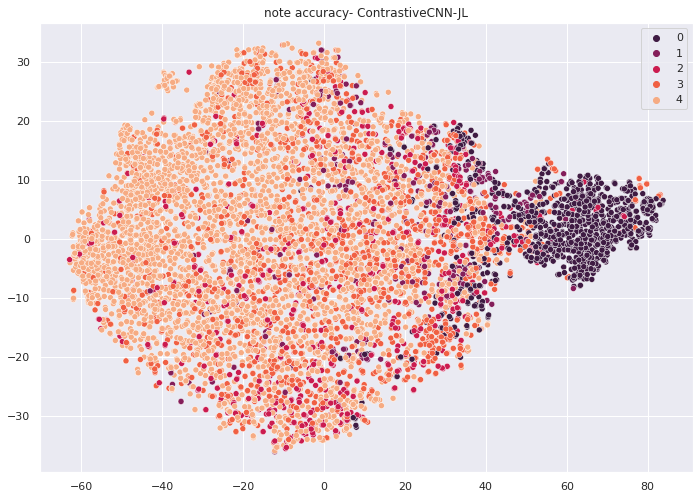

In [34]:
teesne = sns.scatterplot(x=y_embed[:,0], y=y_embed[:,1], hue=y, legend='full', palette=palette).set_title(metric_type[1] + '- ContrastiveCNN-JL')
teesne.figure.savefig('paper_runs/viz/TunedTsneCCNN-JL.pdf', bbox_inches='tight')

In [33]:
s = silhouette_score(preds, y)
print(s)
d = davies_bouldin_score(preds, y)
print(d)

0.09578275
11.002306382423663


In [35]:
#dist = c_loss.euclid(preds[:-1, :], preds[1:,:])
#print(dist.size(), preds.size(), dist)
#dist = c_loss.cosine_sim(preds[:-1, :], preds[1:,:])
#print(dist.size(), preds.size(), dist)
dists = np.zeros((5,5))
mean_pt = np.zeros((5,1))
for x in range(5):
    indices_x = np.argwhere(y == x)
    #mean_pt[x] = torch.mean(torch.tensor(preds[indices_x]), axis=1)
    for z in range(5):
        indices_z = np.argwhere(y == z)
        dists[x,z] = c_loss.euclid(torch.mean(torch.tensor(preds[indices_x]), axis=1),torch.mean(torch.tensor(preds[indices_z]), axis=1))
print(dists)
print(mean_pt)

[[0.         0.97426921 1.17767894 1.16191542 1.39345586]
 [0.97426921 0.         0.25652322 0.25095835 0.45305133]
 [1.17767894 0.25652322 0.         0.04054997 0.24657783]
 [1.16191542 0.25095835 0.04054997 0.         0.25782552]
 [1.39345586 0.45305133 0.24657783 0.25782552 0.        ]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


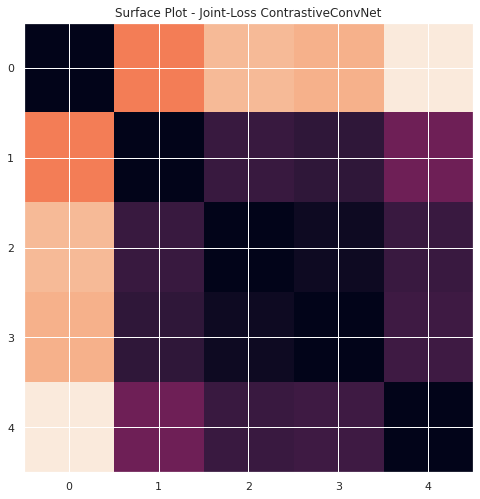

In [29]:
fig, ax = plot.subplots()
ax.set_title('Surface Plot - Joint-Loss ContrastiveConvNet')
plot.imshow(dists)
fig.savefig('paper_runs/viz/surface-mix-ra.pdf', bbox_inches='tight', transparent=True)
fig.savefig('paper_runs/viz/surface-mix-ra.png', bbox_inches='tight', transparent=True)

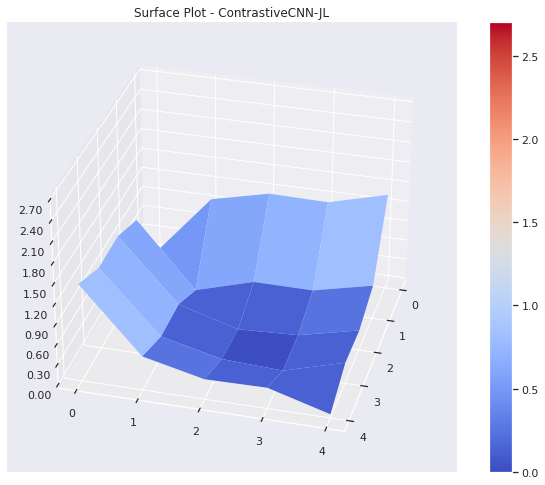

In [36]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
X = np.arange(5)
Y = np.arange(5)
X, Y = np.meshgrid(X, Y)
fig, ax = plot.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, dists, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
# Customize the z axis.
ax.set_zlim(0, 2.7)
ax.set_title('Surface Plot - ContrastiveCNN-JL')
ax.zaxis.set_major_locator(LinearLocator(10))
#ax.yaxis.set_major_locator(LinearLocator(5))
#ax.xaxis.set_major_locator(LinearLocator(5))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(30, 15)
plot.xticks(np.arange(0, 5, 1))
plot.yticks(np.arange(0, 5, 1))
# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
plot.colorbar(surf)
surf.set_clim(vmin=0, vmax=2.7)

In [37]:
fig.savefig('paper_runs/viz/surf-CCNN-JL.pdf', bbox_inches='tight', transparent=True)

Text(0.5, 1.0, 'Rhythm Accuracy- ContrastiveEncoderNet')

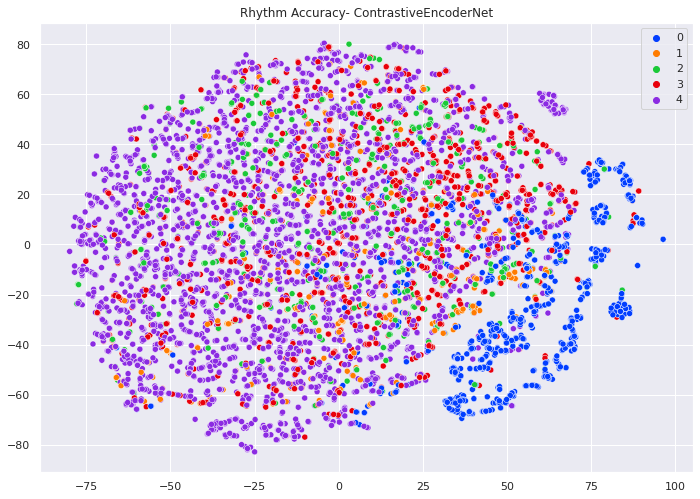

In [228]:
sns.scatterplot(x=y_embed[:,0], y=y_embed[:,1], hue=y, legend='full', palette=palette).set_title(metric_type[2] + '- ContrastiveEncoderNet')

In [39]:
sns.scatterplot(x=x_embed[:,0], y=x_embed[:,1], hue=y, legend='full', palette=palette).set_title('DATASET')
if x_embed.shape[1] == 2:
    fig = plot.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.scatter(x_embed[:,0], x_embed[:,1], s=50, alpha=0.6, cmap=cmap, c=y)
    ax.set_title('DATASET')
elif x_embed.shape[1] == 3:
    fig = plot.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_embed[:,0], x_embed[:,1], x_embed[:,2], s=50, alpha=0.6, cmap=cmap, c=y)
    ax.set_title('DATASET')

NameError: name 'x_embed' is not defined

In [ ]:
if y_embed.shape[1] == 2:
    #sns.scatterplot(x=y_embed[:,0], y=y_embed[:,1], hue=y, legend='full', palette=palette).set_title('PREDICTIONS')
    fig = plot.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.scatter(y_embed[:,0], y_embed[:,1], s=50, alpha=0.6, cmap=cmap, c=y)
    ax.set_title('PREDICTIONS')
if y_embed.shape[1] == 3:
    fig = plot.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y_embed[:,0], y_embed[:,1], y_embed[:,2], s=50, alpha=0.6, cmap=cmap, c=y)
    ax.set_title('PREDICTIONS')